<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/example_kaggle/les_9/improving_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.datasets import mnist
from sklearn.metrics import accuracy_score


In [2]:
# Налаштування параметрів нейромережі
num_classes = 10  # Кількість класів (цифри від 0 до 9)
num_features = 784  # Кількість ознак (28x28 пікселів = 784)

learning_rate = 0.001  # Швидкість навчання
training_steps = 3000  # Кількість ітерацій навчання
batch_size = 256  # Розмір пакету
display_step = 100  # Як часто виводити інформацію про прогрес

# Розмірність шарів мережі
n_hidden_1 = 128  # Кількість нейронів у першому прихованому шарі
n_hidden_2 = 256  # Кількість нейронів у другому прихованому шарі

# Завантажуємо набір даних MNIST (рукописні цифри)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо дані в формат float32 та нормалізуємо їх у діапазон [0,1]
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.  # Нормалізація

# Створюємо об'єкт TensorFlow Dataset для ефективної обробки даних
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Оголошуємо клас для повнозв'язного шару
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")  # Випадкові ваги
        self.b = tf.Variable(tf.zeros([out_features]), name="b")  # Початкові нулі для зміщення (bias)
        self.activation = activation  # Функція активації

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b  # Лінійне перетворення
        return self.activation(y) if self.activation else y  # Застосовуємо активацію, якщо є

# Оголошуємо клас нейромережі
class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1, activation=tf.nn.sigmoid)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, activation=tf.nn.sigmoid)
        self.out_layer = DenseLayer(n_hidden_2, num_classes, activation=tf.nn.softmax)  # Softmax для багатокласової класифікації

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.out_layer(x)

# Функція крос-ентропії для обчислення втрат
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)  # Перетворюємо y_true у one-hot представлення
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)  # Уникаємо логарифма від 0
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))  # Обчислення втрат

# Функція для обчислення точності моделі
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, np.argmax(y_pred, axis=1))  # Порівнюємо прогноз із реальними значеннями

# Створюємо екземпляр нейромережі
neural_net = NN(name="mnist")

# Функція навчання моделі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)  # Стохастичний градієнтний спуск (SGD)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)  # Прогноз мережі
        loss = cross_entropy(pred, output_y)  # Обчислення помилки
    # Обчислення градієнтів для кожного шару
    gradients = g.gradient(loss, [neural_net.layer1.w, neural_net.layer1.b,
                                  neural_net.layer2.w, neural_net.layer2.b,
                                  neural_net.out_layer.w, neural_net.out_layer.b])
    # Оновлення ваг
    optimizer.apply_gradients(zip(gradients, [neural_net.layer1.w, neural_net.layer1.b,
                                              neural_net.layer2.w, neural_net.layer2.b,
                                              neural_net.out_layer.w, neural_net.out_layer.b]))
    return loss

In [4]:

# Історія втрат та точності
loss_history = []
accuracy_history = []

# Процес навчання
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)  # Навчаємо модель на пакеті даних
    if step % display_step == 0:
        pred = neural_net(batch_x)  # Робимо прогноз
        acc = accuracy(pred.numpy(), batch_y.numpy())  # Обчислюємо точність
        loss_history.append(loss.numpy())
        accuracy_history.append(acc)
        print(f"Крок {step}, Втрата: {loss.numpy():.4f}, Точність: {acc:.4f}")


Крок 100, Втрата: 14.4900, Точність: 0.0977
Крок 200, Втрата: 13.4783, Точність: 0.1016
Крок 300, Втрата: 11.9803, Точність: 0.0898
Крок 400, Втрата: 9.9936, Точність: 0.0859
Крок 500, Втрата: 8.5373, Точність: 0.1250
Крок 600, Втрата: 7.5451, Точність: 0.1484
Крок 700, Втрата: 7.2997, Точність: 0.1328
Крок 800, Втрата: 6.9813, Точність: 0.1523
Крок 900, Втрата: 6.6241, Точність: 0.1562
Крок 1000, Втрата: 6.6163, Точність: 0.1367
Крок 1100, Втрата: 6.0110, Точність: 0.1719
Крок 1200, Втрата: 5.9375, Точність: 0.1445
Крок 1300, Втрата: 5.4795, Точність: 0.1484
Крок 1400, Втрата: 5.7080, Точність: 0.1641
Крок 1500, Втрата: 4.9579, Точність: 0.2070
Крок 1600, Втрата: 5.4578, Точність: 0.1758
Крок 1700, Втрата: 5.1289, Точність: 0.1953
Крок 1800, Втрата: 5.4104, Точність: 0.1797
Крок 1900, Втрата: 4.8055, Точність: 0.1836
Крок 2000, Втрата: 4.6514, Точність: 0.2266
Крок 2100, Втрата: 5.0569, Точність: 0.1406
Крок 2200, Втрата: 4.5734, Точність: 0.2305
Крок 2300, Втрата: 4.8583, Точність: 0

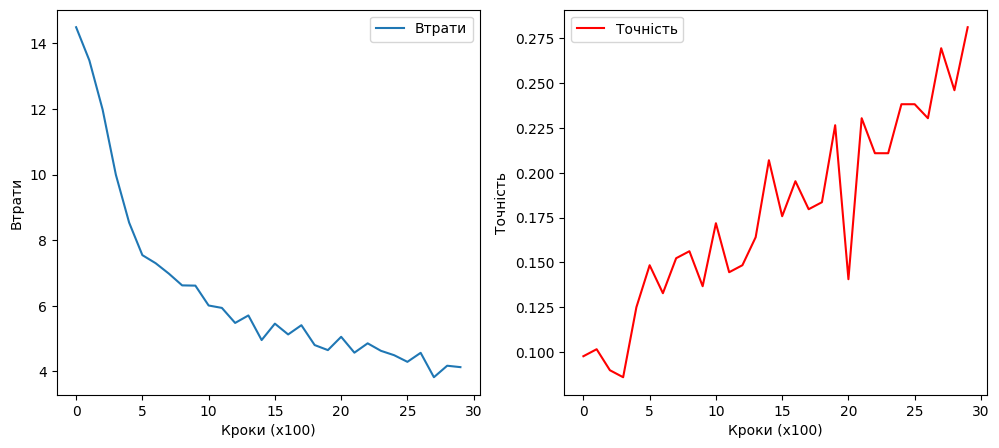

In [6]:
# Візуалізація процесу навчання
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Втрати')
plt.xlabel("Кроки (x100)")
plt.ylabel("Втрати")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Точність', color='red')
plt.xlabel("Кроки (x100)")
plt.ylabel("Точність")
plt.legend()
plt.show()

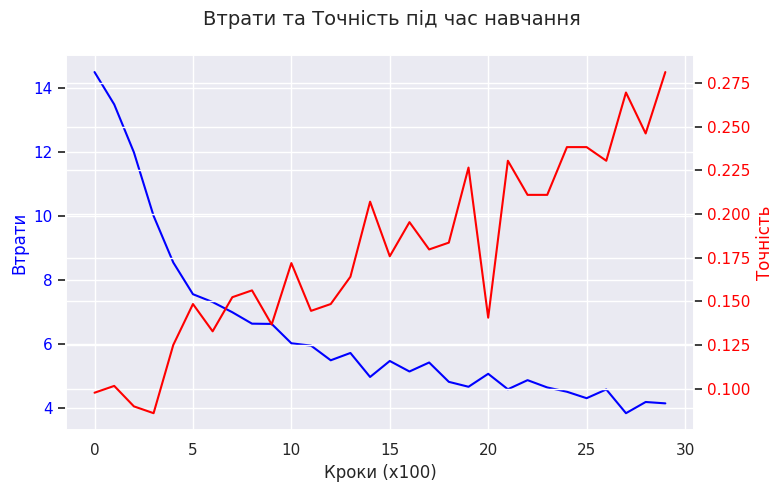

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

fig, ax1 = plt.subplots(figsize=(8, 5))

# Графік втрат
ax1.plot(loss_history, label='Втрати', color='blue')
ax1.set_xlabel("Кроки (x100)")
ax1.set_ylabel("Втрати", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Додаємо другу вісь Y для точності
ax2 = ax1.twinx()
ax2.plot(accuracy_history, label='Точність', color='red')
ax2.set_ylabel("Точність", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle("Втрати та Точність під час навчання", fontsize=14)
fig.tight_layout()
plt.show()


In [17]:
import plotly.graph_objects as go

fig = go.Figure()

# Лінія втрат
fig.add_trace(go.Scatter(
    x=list(range(len(loss_history))),
    y=loss_history,
    mode='lines',
    name='Втрати',
    yaxis='y1',
    line=dict(color='blue')
))

# Лінія точності
fig.add_trace(go.Scatter(
    x=list(range(len(accuracy_history))),
    y=accuracy_history,
    mode='lines',
    name='Точність',
    yaxis='y2',
    line=dict(color='red')
))

# Налаштування осей
fig.update_layout(
    title="Втрати та Точність під час навчання",
    xaxis=dict(title="Кроки (x100)"),
    yaxis=dict(title="Втрати", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
    yaxis2=dict(title="Точність", titlefont=dict(color="red"), tickfont=dict(color="red"),
                overlaying='y', side='right'),
    height=1000, width=1000,
    legend=dict()
)

fig.show()

